# Introduction

The goal of this project is to determine the factors that directly contribute to student success for this online program. Previous EDA showed that the distributions of numeric data did not differ between passing and failing students. Since there are both continuous and categorical values to predict the student outcome, 

## Loading libraries

In [3]:
# Standard
import os
import random
from datetime import datetime, timedelta
import itertools
from subprocess import call
from io import StringIO
import time

# Manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from scipy import stats, optimize, spatial

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image
import graphviz
import pydotplus

# Modeling
from sklearn import datasets, svm, decomposition
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, Normalizer, RobustScaler
from sklearn.datasets import make_classification

# Metrics
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.metrics import silhouette_score, silhouette_samples

## Loading statistical functions

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

def bon_correct(alpha, n):
    return (alpha/n)

# Loading Data

In [7]:
df = pd.read_csv('capstone_2_modeling.csv')

In [8]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [9]:
df.head()

,id_student,gender,disability,age_band,imd_band,highest_education,date_registration,num_of_prev_attempts,final_result,studied_credits,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,2412002,0,0,2,5,2,-38,0,Distinction,90,85.2,93.9,215.0,4.000000,4.0,11.000000,11.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2412002,0,0,2,5,2,-38,0,Distinction,90,85.2,93.9,215.0,1.000000,4.0,6.250000,25.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2412002,0,0,2,5,2,-38,0,Distinction,90,85.2,93.9,215.0,3.000000,3.0,6.000000,6.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2412002,0,0,2,5,2,-38,0,Distinction,90,85.2,93.9,215.0,5.333333,16.0,15.333333,46.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2412002,0,0,2,5,2,-38,0,Distinction,90,85.2,93.9,215.0,2.000000,2.0,3.000000,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27633 entries, 0 to 27632
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_student                   27633 non-null  int64  
 1   gender                       27633 non-null  int64  
 2   disability                   27633 non-null  int64  
 3   age_band                     27633 non-null  int64  
 4   imd_band                     27633 non-null  int64  
 5   highest_education            27633 non-null  int64  
 6   date_registration            27633 non-null  int64  
 7   num_of_prev_attempts         27633 non-null  int64  
 8   final_result                 27633 non-null  object 
 9   studied_credits              27633 non-null  int64  
 10  mean_score                   27633 non-null  float64
 11  mean_assessment_length       27633 non-null  float64
 12  max_assessment_length        27633 non-null  float64
 13  mean_active     

In [11]:
df.describe()

,id_student,gender,disability,age_band,imd_band,highest_education,date_registration,num_of_prev_attempts,studied_credits,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
count,2.763300e+04,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.000000,27633.0,27633.000000,27633.000000
mean,7.150004e+05,0.593855,0.079217,1.358123,4.369269,2.856585,-66.912966,0.120979,78.156371,75.179575,105.105597,170.483335,2.094343,6.891651,7.790057,27.584917,0.106322,0.071255,0.031484,0.100821,0.028770,0.089603,0.121811,0.069555,0.103282,0.080701,0.064705,0.072848,0.058843,0.001737,0.003329,0.012413,0.002931,0.137372,0.005537,0.219520,0.000543,0.008975,0.143415,0.003040,0.037166,0.007419,0.002497,0.070785,0.107625,0.0,0.155683,0.080013
std,5.811275e+05,0.491121,0.270082,0.497897,2.816001,0.740864,48.801351,0.416725,37.001073,15.398346,39.887413,58.671652,1.847331,10.068932,17.035069,90.708900,0.308255,0.257256,0.174625,0.301098,0.167162,0.285617,0.327073,0.254399,0.304333,0.272380,0.246009,0.259891,0.235334,0.041643,0.057605,0.110721,0.054063,0.344246,0.074205,0.413929,0.023293,0.094311,0.350502,0.055052,0.189171,0.085813,0.049909,0.256470,0.309912,0.0,0.362562,0.271318
min,6.516000e+03,0.000000,0.000000,1.000000,0.000000,1.000000,-304.000000,0.000000,30.000000,0.000000,-5.000000,-5.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,4.947890e+05,0.000000,0.000000,1.000000,2.000000,2.000000,-95.000000,0.000000,60.000000,67.250000,83.285714,151.000000,1.000000,2.000000,1.666667,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,5.808830e+05,1.000000,0.000000,1.000000,4.000000,3.000000,-53.000000,0.000000,60.000000,77.629630,108.500000,200.000000,1.000000,4.000000,3.090909,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,6.316500e+05,1.000000,0.000000,2.000000,7.000000,3.000000,-29.000000,0.000000,90.000000,86.066667,129.666667,210.000000,2.500000,8.000000,7.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [12]:
df.shape

(27633, 49)

# Splitting the Data

Now that the data has been encoded, it can now be split into its respective x and y variables. The 'final_result' feature was left untouched since it was the response variable to all the other features. For x data, 'id_student' will be dropped since it serves as more of a categorical variable.

Since the data points were originally ordered by assessment and student, I will need to shuffle the train_test to make sure students at the bottom of the df do not unnecessarily get cut.

In [14]:
x = df.drop(columns = ['id_student', 'final_result'])
y = df[['final_result']]

features = x.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 6022, stratify = y, test_size = 0.25, shuffle = True)

# Scaling

Despite encoding, a few columns are still beyond a comparable scope of eachother. A StandardScaler will be applied to ensure that all values are comparable.

In [16]:
scaler = RobustScaler()
scaler_model = scaler.fit(x_train)

In [17]:
x_train_scale = scaler_model.transform(x_train)
x_test_scale = scaler_model.transform(x_test)

In [18]:
cv_k = StratifiedKFold(5)
n_est_first = [2**i for i in range(7)]
n_est_second = [int(x) for x in np.linspace(start = 100, stop = 20000, num = 20)]
n_est = n_est_first + n_est_second
n_iter = 200
verb = 3 #Extremely long training times for hypertuning required me to make sure that progress was being made

# Simple Decision Tree

In [20]:
dt_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [x for x in np.linspace(0.01, 1.0, 15, endpoint = True)]
}

cv_dt = DecisionTreeClassifier(max_features = 'sqrt', random_state = 6022)

In [21]:
start_time = time.time()
dt_rand = RandomizedSearchCV(
    estimator = cv_dt,
    param_distributions = dt_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
dt_rand_cv = dt_rand.fit(x_train_scale, y_train)
end_time = time.time()
dt_cv_time = end_time - start_time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=1.0;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=1.0;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=1.0;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=1.0;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=1.0;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=110, min_samples_split=0.9292857142857143;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=110, min_samples_split=0.9292857142857143;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=110, min_sample

In [22]:
print("Best Score:" + str(dt_rand_cv.best_score_))
print("Best Parameters: " + str(dt_rand_cv.best_params_))

Best Score:0.6751589229243029
Best Parameters: {'min_samples_split': 0.01, 'max_depth': 110, 'criterion': 'gini'}


In [23]:
dt = DecisionTreeClassifier(**dt_rand_cv.best_params_, max_features = 'sqrt', random_state = 6022)

start_time = time.time()
dt_model = dt.fit(x_train_scale, y_train)
end_time = time.time()
dt_fit_time = end_time - start_time

start_time = time.time()
dt_pred = dt_model.predict(x_test_scale)
end_time = time.time()
dt_pred_time = end_time - start_time

dt_cv_scores_test = cross_val_score(dt_model, x_test_scale, y_test, cv = cv_k, scoring = 'roc_auc')
dt_cv_scores_train = cross_val_score(dt_model, x_train_scale, y_train, cv = cv_k, scoring = 'roc_auc')
print(f'Training CV Score: {dt_cv_scores_train.mean()} +- {dt_cv_scores_train.std()}')
print(f'Testing CV Score: {dt_cv_scores_test.mean()} +- {dt_cv_scores_test.std()}')

Because of the heavy class imbalance, the models cannot be compared using cross-validation scores. The metrics obtained from the confusion matrix will be how the final model is selected.

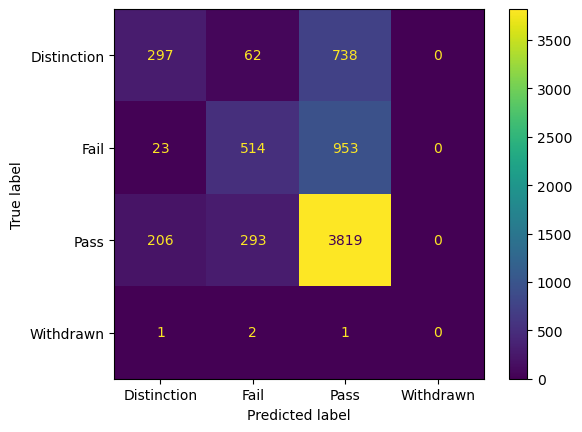

In [26]:
dt_confusion = confusion_matrix(y_test, dt_pred, labels = dt_model.classes_)
dt_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = dt_confusion, display_labels = dt_model.classes_)
dt_confusion_matrix.plot()
plt.show()

In [27]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

 Distinction       0.56      0.27      0.37      1097
        Fail       0.59      0.34      0.44      1490
        Pass       0.69      0.88      0.78      4318
   Withdrawn       0.00      0.00      0.00         4

    accuracy                           0.67      6909
   macro avg       0.46      0.38      0.39      6909
weighted avg       0.65      0.67      0.64      6909



C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


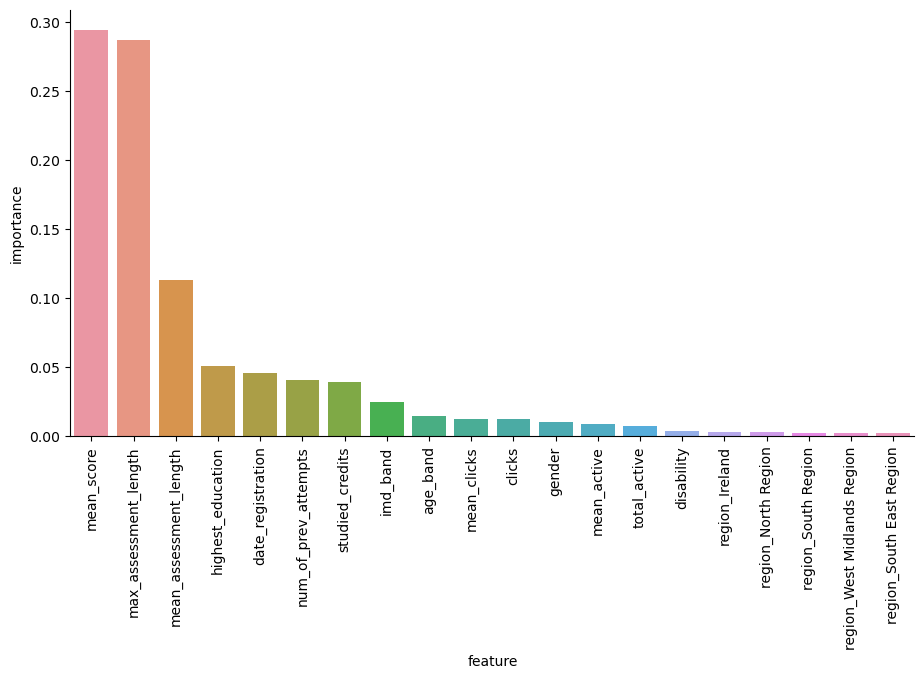

In [28]:
dt_imp = dt_model.feature_importances_
dt_feat_imp_df = pd.DataFrame({'feature': features, 'importance': dt_imp})
dt_sorted = dt_feat_imp_df.sort_values(by = 'importance', ascending = False)
dt_feat_plot = sns.catplot(data = dt_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
dt_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [29]:
print(f'CV time: {dt_cv_time}')
print(f'Fit time: {dt_fit_time}')
print(f'Predict time: {dt_pred_time}')

CV time: 44.36801886558533
Fit time: 0.038008928298950195
Predict time: 0.0010056495666503906


# Random Forest

In [31]:
rf_params = {
    'n_estimators': n_est,
    'criterion': ['gini', 'entropy'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [x for x in np.linspace(0.1, 1.0, 10, endpoint = True)]
}

cv_rf = RandomForestClassifier(max_features = 'sqrt', n_jobs = 4, random_state = 6022)

In [ ]:
start_time = time.time()
rf_rand = RandomizedSearchCV(
    estimator = cv_rf,
    param_distributions = rf_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
rf_rand_cv = rf_rand.fit(x_train_scale, y_train)
end_time = time.time()
rf_cv_time = end_time - start_time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.30000000000000004, n_estimators=1;, score=(train=0.637, test=0.633) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.30000000000000004, n_estimators=1;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.30000000000000004, n_estimators=1;, score=(train=0.625, test=0.625) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.30000000000000004, n_estimators=1;, score=(train=0.625, test=0.625) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.30000000000000004, n_estimators=1;, score=(train=0.625, test=0.625) total time=   0.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=14763;, score=(train=0.625, test=0.625) total time=  23.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=14763;, score=(train=0.625, test=0.625) total time=  23.9s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=14763;, score=(train=0.625, test=0.625) total time=  24.0s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=14763;, score=(train=0.625, test=0.625) total time=  23.8s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=gini, max_depth=60, min_samples_split=0.5, n_estimators=14763;, score=(train=0.625, test=0.625) total time=  24.4s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=entropy, max_depth=80, min_samples_split=0.1, n_estimators=100;, score=(train=0.639, test=0.638) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/5] END criterion=entropy, max_depth=80, min_samples_split=0.1, n_estimators=100;, score=(train=0.636, test=0.637) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/5] END criterion=entropy, max_depth=80, min_samples_split=0.1, n_estimators=100;, score=(train=0.634, test=0.630) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/5] END criterion=entropy, max_depth=80, min_samples_split=0.1, n_estimators=100;, score=(train=0.634, test=0.633) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/5] END criterion=entropy, max_depth=80, min_samples_split=0.1, n_estimators=100;, score=(train=0.637, test=0.635) total time=   0.2s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/5] END criterion=gini, max_depth=90, min_samples_split=1.0, n_estimators=11621;, score=(train=0.625, test=0.625) total time=  18.5s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print("Best Score:" + str(rf_rand_cv.best_score_))
print("Best Parameters: " + str(rf_rand_cv.best_params_))

In [ ]:
rf = RandomForestClassifier(**rf_rand_cv.best_params_, max_features = 'sqrt', n_jobs = 4, random_state = 6022)

start_time = time.time()
rf_model = rf.fit(x_train_scale, y_train)
end_time = time.time()
rf_fit_time = end_time = start_time

start_time = time.time()
rf_pred = rf_model.predict(x_test_scale)
end_time = time.time()
rf_pred_time = end_time - start_time

In [ ]:
rf_confusion = confusion_matrix(y_test, rf_pred, labels = rf_model.classes_)
rf_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = rf_confusion, display_labels = rf_model.classes_)
rf_confusion_matrix.plot()
plt.show()

In [ ]:
print(classification_report(y_test, rf_pred))

In [ ]:
rf_imp = rf_model.feature_importances_
rf_feat_imp_df = pd.DataFrame({'feature': features, 'importance': rf_imp})
rf_sorted = rf_feat_imp_df.sort_values(by = 'importance', ascending = False)
rf_feat_plot = sns.catplot(data = rf_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
rf_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [ ]:
print(f'CV time: {rf_cv_time}')
print(f'Fit time: {rf_fit_time}')
print(f'Predict time: {rf_pred_time}')

# K-Nearest Neighbors

In [ ]:
knn_params = {
    'n_neighbors': n_est_first,
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

cv_knn = KNeighborsClassifier(n_jobs = 4, random_state = 6022)

In [ ]:
start_time = time.time()
knn_rand = RandomizedSearchCV(
    estimator = cv_knn,
    param_distributions = knn_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
knn_rand_cv = knn_rand.fit(x_train_scale, y_train)
end_time = time.time()
knn_cv_time = end_time - start_time

In [ ]:
print("Best Score:" + str(knn_rand_cv.best_score_))
print("Best Parameters: " + str(knn_rand_cv.best_params_))

In [ ]:
knn = KNeighborsClassifer(**knn_rand_cv.best_params_, random_state = 6022)

start_time = time.time()
knn_model = knn.fit(x_train_scale, y_train)
end_time = time.time()
knn_fit_time = end_time - start_time

start_time = time.time()
knn_pred = knn_model.predict(x_test_scale)
end_time = time.time()
knn_pred_time = end_time - start_time

In [ ]:
knn_confusion = confusion_matrix(y_test, knn_pred, labels = knn_model.classes_)
knn_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = knn_confusion, display_labels = knn_model.classes_)
knn_confusion_matrix.plot()
plt.show()

In [ ]:
print(classification_report(y_test, knn_pred))

In [ ]:
knn_imp = knn_model.feature_importances_
knn_feat_imp_df = pd.DataFrame({'feature': features, 'importance': knn_imp})
knn_sorted = knn_feat_imp_df.sort_values(by = 'importance', ascending = False)
knn_feat_plot = sns.catplot(data = knn_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
knn_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [ ]:
print(f'CV time: {knn_cv_time}')
print(f'Fit time: {knn_fit_time}')
print(f'Predict time: {knn_pred_time}')

# Logistic Regression

In [ ]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': [0.001, 0.1, 1, 10, 100]
}

cv_lr = LogisticRegression(n_jobs = 4, random_state = 6022)

In [ ]:
start_time = time.time()
lr_rand = RandomizedSearchCV(
    estimator = cv_lr,
    param_distributions = lr_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
lr_rand_cv = lr_rand.fit(x_train_scale, y_train)
end_time = time.time()
lr_cv_time = end_time - start_time

In [ ]:
print("Best Score:" + str(lr_rand_cv.best_score_))
print("Best Parameters: " + str(lr_rand_cv.best_params_))

In [ ]:
lr = LogisticRegression(**lr_rand_cv.best_params_, random_state = 6022)

start_time = time.time()
lr_model = lr.fit(x_train_scale, y_train)
end_time = time.time()
lr_fit_time = end_time - start_time

start_time = time.time()
lr_pred = lr_model.predict(x_test_scale)
end_time = time.time()
lr_pred_time = end_time - start_time

In [ ]:
lr_confusion = confusion_matrix(y_test, lr_pred, labels = lr_model.classes_)
lr_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = lr_confusion, display_labels = lr_model.classes_)
lr_confusion_matrix.plot()
plt.show()

In [ ]:
print(classification_report(y_test, lr_pred))

In [ ]:
lr_imp = lr_model.feature_importances_
lr_feat_imp_df = pd.DataFrame({'feature': features, 'importance': lr_imp})
lr_sorted = lr_feat_imp_df.sort_values(by = 'importance', ascending = False)
lr_feat_plot = sns.catplot(data = lr_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
lr_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [ ]:
print(f'CV time: {lr_cv_time}')
print(f'Fit time: {lr_fit_time}')
print(f'Predict time: {lr_pred_time}')

# Gradient Boosting

In [ ]:
gb_params = {
    'n_estimators': n_est_second,
    'learning_rate': [0.1, 0.25, 0.5, 1],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [x for x in np.linspace(0.1, 1.0, 10, endpoint = True)]
}

cv_gb = GradientBoostingClassifier(random_state = 6022)

In [ ]:
start_time = time.time()
gb_rand = RandomizedSearchCV(
    estimator = cv_gb,
    param_distributions = gb_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
gb_rand_cv = gb_rand.fit(x_train_scale, y_train)
end_time = time.time()
gb_cv_time = end_time - start_time

In [ ]:
print("Best Score:" + str(gb_rand_cv.best_score_))
print("Best Parameters: " + str(gb_rand_cv.best_params_))

In [ ]:
gb = GradientBoostingClassifier(**gb_rand_cv.best_params_, random_state = 6022)

start_time = time.time()
gb_model = gb.fit(x_train_scale, y_train)
end_time = time.time()
gb_fit_time = end_time - start_time

start_time = time.time()
gb_pred = gb_model.predict(x_test_scale)
end_time = time.time()
gb_pred_time = end_time - start_time

In [ ]:
gb_confusion = confusion_matrix(y_test, gb_pred, labels = gb_model.classes_)
gb_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = gb_confusion, display_labels = gb_model.classes_)
gb_confusion_matrix.plot()
plt.show()

In [ ]:
print(classification_report(y_test, gb_pred))

In [ ]:
gb_imp = gb_model.feature_importances_
gb_feat_imp_df = pd.DataFrame({'feature': features, 'importance': gb_imp})
gb_sorted = gb_feat_imp_df.sort_values(by = 'importance', ascending = False)
gb_feat_plot = sns.catplot(data = gb_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
gb_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [ ]:
print(f'CV time: {gb_cv_time}')
print(f'Fit time: {gb_fit_time}')
print(f'Predict time: {gb_pred_time}')

# KMeans Clustering

In [ ]:
km_params = {
    'init': ['k-means++', 'random'],
    'max_iter': n_est
}

cv_km = KMeans(n_clusters = 4, random_state = 6022)

In [ ]:
start_time = time.time()
km_rand = RandomizedSearchCV(
    estimator = cv_km,
    param_distributions = km_params,
    cv = cv_k,
    n_iter = n_iter,
    verbose = verb,
    return_train_score = True,
    random_state = 6022
)
km_rand_cv = km_rand.fit(x_train_scale, y_train)
end_time = time.time()
km_cv_time = end_time - start_time

In [ ]:
print("Best Score:" + str(km_rand_cv.best_score_))
print("Best Parameters: " + str(km_rand_cv.best_params_))

In [ ]:
km = KMeans(**km_rand_cv.best_params_, n_clusters = 4, random_state = 6022)

start_time = time.time()
km_model = km.fit(x_train_scale, y_train)
end_time = time.time()
km_fit_time = end_time - start_time

start_time = time.time()
km_pred = km_model.predict(x_test_scale)
end_time = time.time()
km_pred_time = end_time - start_time

In [ ]:
km_confusion = confusion_matrix(y_test, km_pred, labels = km_model.classes_)
km_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix = km_confusion, display_labels = km_model.classes_)
km_confusion_matrix.plot()
plt.show()

In [ ]:
print(classification_report(y_test, km_pred))

In [ ]:
km_imp = km_model.feature_importances_
km_feat_imp_df = pd.DataFrame({'feature': features, 'importance': km_imp})
km_sorted = km_feat_imp_df.sort_values(by = 'importance', ascending = False)
km_feat_plot = sns.catplot(data = km_sorted.head(20), kind = 'bar', x = 'feature', y = 'importance', height = 5, aspect = 2)
km_feat_plot = plt.xticks(rotation = 90)
plt.show()

In [ ]:
print(f'CV time: {km_cv_time}')
print(f'Fit time: {km_fit_time}')
print(f'Predict time: {km_pred_time}')